# Submission 3 &ndash; Final Submission

## Instructions

- Fill out the *Basic Information* and the *Results* sections.
- Make sure that this `.ipynb` file displays correctly in the GitHub file preview, including any visual output.
- If you find that any output does not display correctly, include a static screenshot as an image. For interactive outputs, add a link to a short screencast located in your repository.
- Push all required files before the deadline.

---
## Basic Information

**Team Name:** The Leading Figures

**Team Members:**
- Nikolaus Schwingshandl
- Mykhailo Stasiuk
- Muhammed Aziz Tepegöz
- Thomas Kovacsits

**Dataset Description:**  
(max. 75 words; this serves just as a reminder)

The dataset contains extensive data on different energy related metrics for countries around the world over several decades. It includes various attributes, such as the energy consumption (primary energy, per capita, and growth rates), energy mix, electricity mix and other relevant metrics.

---

## Code

Here you may place any code that is not an immediate part of your submission. Only the content of the *Results* sections will be graded for this submission.

In [24]:
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import Output, HBox, VBox, HTML
from IPython.display import clear_output, display, Image
import ipywidgets as widgets
from ipywidgets import Layout
import pandas as pd
import numpy as np
import math

owid_data: pd.DataFrame = pd.read_csv('owid-energy-data.csv')

def prepare_data(data: pd.DataFrame, year: int) -> pd.DataFrame:
    # '*_share_energy' is being adjusted by its efficiency, so its not useful for our plot
    # columns = ['country', 'year', 'iso_code'] + [x for x in owid_data.columns if 'share' in x and 'elec' in x]
    columns = ['country', 'year', 'iso_code'] + ['solar_share_elec', 'wind_share_elec', 'oil_share_elec', 'nuclear_share_elec', 'hydro_share_elec', 'gas_share_elec', 'coal_share_elec', 'biofuel_share_elec']

    data = data[columns]

    # Drop all aggregates
    data = data[data['iso_code'].notna()]

    # Filter by year
    data = data[data['year'] == year]

    # data = data[(1980 <= data['year']) & (data['year'] <= 2020)]

    data.iloc[:, 3:] = data.iloc[:, 3:].fillna(0)
    
    return data

energy_colors = {
    'solar_share_elec': '#f0cc2e',
    'wind_share_elec': '#bc5090',
    'oil_share_elec': '#a9522e',
    'nuclear_share_elec': '#9dbd3d',
    'hydro_share_elec': '#82a0e5',
    'gas_share_elec': '#8f66ff',
    'coal_share_elec': '#545568',
    'biofuel_share_elec': '#51a16a'
}

energy_columns = {
    'Solar': 'solar_share_elec',
    'Wind': 'wind_share_elec',
    'Oil': 'oil_share_elec',
    'Nuclear': 'nuclear_share_elec',
    'Hydro': 'hydro_share_elec',
    'Gas': 'gas_share_elec',
    'Coal': 'coal_share_elec',
    'Biofuel': 'biofuel_share_elec'
}

selected_country = None

year_slider = widgets.IntSlider(
    min=2000,
    max=2020,
    step=1,
    description='Year:     ',
)

energy_dropdown = widgets.Dropdown(
    options=list(energy_columns.keys()),
    description='Energy Source:',
    value=None
)

fig_widget = None
camera_state = None
click_times = []

def plot_map(owid_data: pd.DataFrame, year: int, energy_source: str = 'Solar'):
    global fig_widget, camera_state
    data = prepare_data(owid_data, year)
    
    energy_column = energy_columns.get(energy_source)
    selected_color = energy_colors.get(energy_column)

    # print(camera_state)
    if 'fig_widget' in globals() and fig_widget is not None and fig_widget.data and not camera_state:
        camera_state = fig_widget.layout.geo['projection']
    # print(camera_state)
    
    if energy_source is not None:
        fig = px.choropleth(
            data, 
            locations='iso_code', 
            color=energy_column, 
            title=f'{energy_source} power share by country ({year})', 
            width=600, 
            height=600, 
            color_continuous_scale=['white', selected_color],
            range_color=[0, data[energy_column].max()],
        )
        
        fig.update_traces(
            customdata=data.apply(lambda row: f"{row['country']}: {row[energy_column]:.2f}%" if row[energy_column] != -1 else "No Data", axis=1),
            hovertemplate='%{customdata}'
        )

        fig.update_layout(
            coloraxis_colorbar=dict(
                orientation='h',
                x=0.5,
                xanchor='center',
                y=-0.2,
                title=f"{energy_source} power share (%)",
                tickvals=[0, data[energy_column].max()],
                ticktext=[f"0%", f"{int(np.ceil(data[energy_column].max()))}%"],
            )
        )
    else:
        fig = px.choropleth(
            None,
            color=energy_column, 
            title=f'Please select the energy source first', 
            width=600, 
            height=600, 
        )

    
    fig.update_geos(
        projection_type="orthographic",
        lakecolor="#86d7ff",
        showocean=True, 
        oceancolor="#86d7ff",
        landcolor="white", 
        showcountries=True, 
        showland=True,
    )
    
    fig_widget = go.FigureWidget(fig)
    fig_bar = go.FigureWidget(
        go.Bar(
            x=[],
            y=[],
            marker=dict(color=["#FFFFFF"])
        )
    )
    # print(selected_country)
    if selected_country is not None:
        for i, layer in enumerate(fig_widget.data):
            if layer.name and layer.name.startswith("Selected:"):
                fig_widget.data = tuple(
                    d for j, d in enumerate(fig_widget.data) if j != i
                )
                break

        country_data = data[data['country'] == selected_country].iloc[0]
        selected_iso = data[data['country'] == selected_country]['iso_code'].values[0]
        fig_widget.add_scattergeo(
            locations=[selected_iso],
            locationmode='ISO-3',
            marker=dict(size=20, color='rgba(0,0,0,0)', line=dict(color='black', width=2)),
            name=f"Selected: {selected_country}",
            showlegend=False,
            hoverinfo='skip'  # Prevent interception of clicks
        )

        shares = [(key, country_data.get(column, 0)) for key, column in energy_columns.items()]
        filtered_shares = [(key, share) for key, share in shares if share > 0]
    
        if filtered_shares:
            filtered_shares.sort(key=lambda x: x[1], reverse=True)
            energy_sources, values = zip(*filtered_shares)
        else:
            energy_sources, values = [], []
        
        fig_bar.data = []
        fig_bar.add_trace(
            go.Bar(
                x=list(energy_sources),
                y=[value if value >=1 else 1 for value in values],
                text=[f"{round(value, 2):.2f}%" if value >= 1 else "<1%" for value in values],
                textposition='outside',
                marker=dict(
                    color=[energy_colors[energy_columns[source]] if source == energy_source else "#D3D3D3" for source in energy_sources],
                    line=dict(
                        color='black',
                        width=0.3
                    )
                ),
                hoverinfo='none',
                showlegend=False,
            )
        )

        fig_bar.update_layout(
            title={
                'text': f"Energy shares for {country_data['country']} ({country_data['year']})",
                'x': 0,
                'xanchor': 'left',
                'y': 0.95,
                'yanchor': 'top',
            },
            xaxis=dict(
                title="Energy Source",
                fixedrange=True,
                showgrid=False,
                visible=True,
            ),
            yaxis=dict(
                title="Share (%)",
                type='linear',
                fixedrange=True,
                showgrid=True,
                visible=True,
                gridcolor='lightgray',
            ),
            plot_bgcolor='white',
            paper_bgcolor='white',
            showlegend=False,
            # margin=dict(l=0, r=0, t=0, b=0),  # Remove margins
        )
    
    else:
        fig_bar.update_layout(
            title={'text':'' if energy_source is None else 'Double click on a country to see its energy mix'},
            xaxis=dict(visible=False),  # Hide x-axis
            yaxis=dict(visible=False),  # Hide y-axis
            plot_bgcolor='white',       # Set background to white
            # margin=dict(l=0, r=0, t=0, b=0),  # Remove margins
        )

    if camera_state:
        fig_widget.layout.geo['projection'] = camera_state

        camera_state = None
    
    bar_output = Output()

    def update_bar_chart(trace, points, selector):
        global selected_country
        if points.point_inds:
            idx = points.point_inds[0]
            country_data = data.iloc[idx]

            # Remove existing scatter geo layer for the previous selection
            if selected_country:
                for i, layer in enumerate(fig_widget.data):
                    if layer.name and layer.name.startswith("Selected:"):
                        fig_widget.data = tuple(
                            d for j, d in enumerate(fig_widget.data) if j != i
                        )
                        break
            # print(selected_country)
            if selected_country == country_data['country']:
                selected_country = None
                with bar_output:
                    bar_output.clear_output(wait=True)
                    fig_bar.data = []
                    fig_bar.update_layout(
                        title={'text':''},
                        xaxis=dict(visible=False),  # Hide x-axis
                        yaxis=dict(visible=False),  # Hide y-axis
                        plot_bgcolor='white',       # Set background to white
                        # margin=dict(l=0, r=0, t=0, b=0),  # Remove margins
                    )
                    
                    fig_bar.show()
                return
            else:
                selected_country = country_data['country']
                selected_iso = data[data['country'] == selected_country]['iso_code'].values[0]
                fig_widget.add_scattergeo(
                    locations=[selected_iso],
                    locationmode='ISO-3',
                    marker=dict(size=20, color='rgba(0,0,0,0)', line=dict(color='black', width=2)),
                    name=f"Selected: {selected_country}",
                    showlegend=False,
                    hoverinfo='skip'  # Prevent interception of clicks
                )
                # print(selected_country)
                # fig_widget.show()

                
            
            shares = [(key, country_data.get(column, 0)) for key, column in energy_columns.items()]
            filtered_shares = [(key, share) for key, share in shares if share > 0]
    
            if filtered_shares:
                filtered_shares.sort(key=lambda x: x[1], reverse=True)
                energy_sources, values = zip(*filtered_shares)
            else:
                energy_sources, values = [], []
    
            with bar_output:
                bar_output.clear_output(wait=True)
                fig_bar.data = []
                fig_bar.add_trace(
                    go.Bar(
                        x=list(energy_sources),
                        y=[value if value >=1 else 1 for value in values],
                        text=[f"{round(value, 2):.2f}%" if value >= 1 else "<1%" for value in values],
                        textposition='outside',
                        marker=dict(
                            color=[energy_colors[energy_columns[source]] if source == energy_source else "#D3D3D3" for source in energy_sources],
                            line=dict(
                                color='black',
                                width=0.3
                            )
                        ),
                        hoverinfo='none',
                        showlegend=False,
                    )
                )
    
                fig_bar.update_layout(
                    title={
                        'text': f"Energy shares for {country_data['country']} ({country_data['year']})",
                        'x': 0,
                        'xanchor': 'left',
                        'y': 0.95,
                        'yanchor': 'top',
                    },
                    xaxis=dict(
                        title="Energy Source",
                        fixedrange=True,
                        showgrid=False,
                        visible=True,
                    ),
                    yaxis=dict(
                        title="Share (%)",
                        type='linear',
                        fixedrange=True,
                        showgrid=True,
                        visible=True,
                        gridcolor='lightgray',
                    ),
                    plot_bgcolor='white',
                    paper_bgcolor='white',
                    showlegend=False,
                    # margin=dict(l=0, r=0, t=0, b=0),  # Remove margins
                )

                fig_bar.show()

    def handle_double_click(trace, points, selector):
        global click_times, camera_state
        from time import time
    
        # Record the time of the click
        current_time = time()
        click_times.append(current_time)
    
        # Keep only the last two clicks
        if len(click_times) > 2:
            click_times.pop(0)
    
        # Detect double-click
        if len(click_times) == 2 and (click_times[1] - click_times[0]) < 0.25:  # 250 ms threshold
            # Capture the current geo projection state before updating the chart
            # print('double click')
            if fig_widget.layout.geo:
                camera_state = fig_widget.layout.geo['projection']

            update_bar_chart(trace, points, selector)
            
            # # Temporarily change the dropdown value to force a refresh
            # original_value = energy_dropdown.value
            # temp_value = list(energy_dropdown.options)[0] if original_value != list(energy_dropdown.options)[0] else list(energy_dropdown.options)[1]
            
            # # Update the widget to a different value, then back to the original
            # energy_dropdown.value = temp_value
            # energy_dropdown.value = original_value
            # Temporarily change the dropdown value to force a refresh
            original_value = year_slider.value
            temp_value = original_value + 1 if original_value < year_slider.max else original_value - 1
            
            # Update the widget to a different value, then back to the original
            year_slider.value = temp_value
            year_slider.value = original_value

    # def clear_bar(*args):
    #     with bar_output:
    #         bar_output.clear_output(wait=True)
    #         fig_bar.data = []
    #         fig_bar.update_layout(
    #             title={'text':''},
    #             xaxis=dict(visible=False),  # Hide x-axis
    #             yaxis=dict(visible=False),  # Hide y-axis
    #             plot_bgcolor='white',       # Set background to white
    #             # margin=dict(l=0, r=0, t=0, b=0),  # Remove margins
    #         )
            
    #         fig_bar.show()
    # def on_unhover(*args):
        # print('Unhovering!!!!!')
    
    # fig_widget.data[0].on_click(update_bar_chart)
    fig_widget.data[0].on_click(handle_double_click)
    # fig_widget.data[0].on_unhover(on_unhover)

    grid_layout = HBox(
        [fig_widget, fig_bar], 
        layout=Layout(justify_content='space-between', height='100%')
    )
    display(grid_layout)

    return grid_layout

# Uncomment the following to see the visualization B1
    
# interactive_output = widgets.interactive_output(plot_map, {'owid_data': widgets.fixed(owid_data), 'year': year_slider, 'energy_source': energy_dropdown})
# display(VBox([HBox([year_slider, energy_dropdown]), interactive_output]))

'''
B2 Section
'''

'''
Black Hat
'''

import dash
from dash import html, dcc
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px

def create_black_hat(
    final_dataset: pd.DataFrame,
    kyoto_countries: list = None,
    paris_countries: list = None,
    gapminder_colors: dict = None,
    app_name: str = "__main__",
    run_server: bool = True,
    debug: bool = False,
    port: int = 8056
):
    """
    Creates and optionally runs a Dash application for visualizing electricity demand and GDP per capita.

    Parameters:
    - final_dataset (pd.DataFrame): The dataset containing necessary columns.
    - kyoto_countries (list, optional): List of countries that signed the Kyoto Protocol.
    - paris_countries (list, optional): List of countries that signed the Paris Agreement.
    - gapminder_colors (dict, optional): Mapping of continents to colors.
    - app_name (str, optional): Name of the Dash app. Defaults to "__main__".
    - run_server (bool, optional): Whether to run the server immediately. Defaults to True.
    - debug (bool, optional): Whether to run the server in debug mode. Defaults to False.
    - port (int, optional): Port number for the Dash server. Defaults to 8056.

    Returns:
    - dash.Dash: The initialized Dash app.
    """

    # Initialize Dash app
    app = dash.Dash(__name__)

    # Use provided country lists or define defaults
    if kyoto_countries is None:
        kyoto_countries = [
            "Afghanistan", "Albania", "Algeria", "Andorra", "Angola",
            "Antigua and Barbuda", "Argentina", "Armenia", "Australia",
            "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh",
            "Barbados", "Belarus", "Belgium", "Belize", "Benin", "Bhutan",
            "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil",
            "Brunei", "Bulgaria", "Burkina Faso", "Burundi", "Cambodia",
            "Cameroon", "Canada", "Cape Verde", "Central African Republic",
            "Chad", "Chile", "China", "Colombia", "Comoros",
            "Congo (Democratic Republic)", "Congo (Republic)", "Cook Islands",
            "Costa Rica", "Croatia", "Cuba", "Cyprus", "Czech Republic",
            "Denmark", "Djibouti", "Dominica", "Dominican Republic",
            "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea",
            "Estonia", "Eswatini", "Ethiopia", "European Union", "Fiji",
            "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany",
            "Ghana", "Greece", "Grenada", "Guatemala", "Guinea",
            "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hungary",
            "Iceland", "India", "Indonesia", "Iran", "Iraq", "Ireland",
            "Israel", "Italy", "Ivory Coast", "Jamaica", "Japan", "Jordan",
            "Kazakhstan", "Kenya", "Kiribati", "Korea (North)", "Korea (South)",
            "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho",
            "Liberia", "Libya", "Liechtenstein", "Lithuania", "Luxembourg",
            "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta",
            "Marshall Islands", "Mauritania", "Mauritius", "Mexico",
            "Micronesia", "Moldova", "Monaco", "Mongolia", "Montenegro",
            "Morocco", "Mozambique", "Myanmar", "Namibia", "Nauru", "Nepal",
            "Netherlands", "New Zealand", "Nicaragua", "Niger", "Nigeria",
            "Niue", "North Macedonia", "Norway", "Oman", "Pakistan", "Palau",
            "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines",
            "Poland", "Portugal", "Qatar", "Romania", "Russia", "Rwanda",
            "Saint Kitts and Nevis", "Saint Lucia",
            "Saint Vincent and the Grenadines", "Samoa", "San Marino",
            "Sao Tome and Principe", "Saudi Arabia", "Senegal", "Serbia",
            "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia",
            "Solomon Islands", "Somalia", "South Africa", "South Sudan",
            "Spain", "Sri Lanka", "Sudan", "Suriname", "Sweden",
            "Switzerland", "Syria", "Tajikistan", "Tanzania", "Thailand",
            "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago", "Tunisia",
            "Turkey", "Turkmenistan", "Tuvalu", "Uganda", "Ukraine",
            "United Arab Emirates", "United Kingdom", "Uruguay", "Uzbekistan"
        ]

    if paris_countries is None:
        paris_countries = [
            "Afghanistan", "Albania", "Algeria", "Andorra", "Angola",
            "Antigua and Barbuda", "Argentina", "Armenia", "Australia",
            "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh",
            "Barbados", "Belarus", "Belgium", "Belize", "Benin", "Bhutan",
            "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil",
            "Brunei Darussalam", "Bulgaria", "Burkina Faso", "Burundi",
            "Cabo Verde", "Cambodia", "Cameroon", "Canada", "Central African Republic",
            "Chad", "Chile", "China", "Colombia", "Comoros", "Congo",
            "Cook Islands", "Costa Rica", "Côte d'Ivoire", "Croatia", "Cuba",
            "Cyprus", "Czech Republic", "Democratic People's Republic of Korea",
            "Democratic Republic of the Congo", "Denmark", "Djibouti",
            "Dominica", "Dominican Republic", "Ecuador", "Egypt", "El Salvador",
            "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini", "Ethiopia",
            "European Union", "Fiji", "Finland", "France", "Gabon", "Gambia",
            "Georgia", "Germany", "Ghana", "Greece", "Grenada", "Guatemala",
            "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras",
            "Hungary", "Iceland", "India", "Indonesia",
            "Iran (Islamic Republic of)", "Iraq", "Ireland", "Israel", "Italy",
            "Jamaica", "Japan", "Jordan", "Kazakhstan", "Kenya", "Kiribati",
            "Kuwait", "Kyrgyzstan", "Lao People's Democratic Republic", "Latvia",
            "Lebanon", "Lesotho", "Liberia", "Libya", "Liechtenstein",
            "Lithuania", "Luxembourg", "Madagascar", "Malawi", "Malaysia",
            "Maldives", "Mali", "Malta", "Marshall Islands", "Mauritania",
            "Mauritius", "Mexico", "Micronesia (Federated States of)", "Monaco",
            "Mongolia", "Montenegro", "Morocco", "Mozambique", "Myanmar",
            "Namibia", "Nauru", "Nepal", "Netherlands", "New Zealand",
            "Nicaragua", "Niger", "Nigeria", "Niue", "North Macedonia",
            "Norway", "Oman", "Pakistan", "Palau", "Panama", "Papua New Guinea",
            "Paraguay", "Peru", "Philippines", "Poland", "Portugal", "Qatar",
            "Republic of Korea", "Republic of Moldova", "Romania",
            "Russian Federation", "Rwanda", "Saint Kitts and Nevis",
            "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa",
            "San Marino", "Sao Tome and Principe", "Saudi Arabia", "Senegal",
            "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia",
            "Slovenia", "Solomon Islands", "Somalia", "South Africa",
            "South Sudan", "Spain", "Sri Lanka", "State of Palestine",
            "Sudan", "Suriname", "Sweden", "Switzerland",
            "Syrian Arab Republic", "Tajikistan", "Thailand", "Timor-Leste",
            "Togo", "Tonga", "Trinidad and Tobago", "Tunisia", "Türkiye",
            "Turkmenistan", "Tuvalu", "Uganda", "Ukraine",
            "United Arab Emirates", "United Kingdom of Great Britain and Northern Ireland",
            "United Republic of Tanzania", "United States of America",
            "Uruguay", "Uzbekistan", "Vanuatu",
            "Venezuela (Bolivarian Republic of)", "Viet Nam", "Yemen",
            "Zambia", "Zimbabwe"
        ]

    if gapminder_colors is None:
        gapminder_colors = {
            "Europe": "#1f77b4",
            "Asia": "#38a638",
            "Africa": "#cc3d3e",
            "North America": "#e3832d",
            "South America": "#ffbb78",
            "Oceania": "#36bcc9"
        }

    # Copy the dataset to avoid modifying the original
    df = final_dataset.copy()

    # Add protocol columns
    df["Kyoto_Protocol"] = df["Country"].isin(kyoto_countries).astype(int)
    df["Paris_Agreement"] = df["Country"].isin(paris_countries).astype(int)

    # Define the app layout
    app.layout = html.Div([
        html.Div([
            dcc.Graph(id="scatter-plot", style={"width": "100%"}, config={'displayModeBar': False}),
        ], style={"flex": "3"}),

        html.Div([
            html.Label(
                "Select Countries:",
                style={
                    "margin-top": "20px",
                    "color": "#242526",
                    "font-family": "Arial",
                    "font-size": "17px"
                }
            ),
            dcc.Dropdown(
                id="country-select",
                options=[
                    {"label": country, "value": country} 
                    for country in sorted(df["Country"].unique())
                ],
                placeholder="Search and select countries...",
                multi=True,
                style={"margin-top": "10px", "width": "100%"}
            )
        ], style={
            "position": "absolute",
            "top": "250px",
            "left": "1200px",
            "width": "220px"
        }),

        html.Div([
            html.Label(
                "Select Protocol:",
                style={
                    "margin-top": "20px",
                    "color": "#242526",
                    "font-family": "Arial",
                    "font-size": "17px"
                }
            ),
            dcc.Dropdown(
                id="protocol-select",
                options=[
                    {"label": "Kyoto Protocol", "value": "Kyoto_Protocol"},
                    {"label": "Paris Agreement", "value": "Paris_Agreement"},
                ],
                placeholder="Select a protocol...",
                style={"margin-top": "10px", "width": "100%"}
            )
        ], style={
            "position": "absolute",
            "top": "330px",
            "left": "1200px",
            "width": "220px"
        })

    ], style={
        "display": "flex",
        "font-family": "Helvetica",
        "font-size": "13px"
    })

    @app.callback(
        Output("scatter-plot", "figure"),
        [
            Input("country-select", "value"),
            Input("protocol-select", "value")
        ]
    )
    def update_graph(selected_countries, selected_protocol):
        """
        Updates the scatter plot based on selected countries and protocol.

        Parameters:
        - selected_countries (list): List of selected countries.
        - selected_protocol (str): Selected protocol ('Kyoto_Protocol' or 'Paris_Agreement').

        Returns:
        - plotly.graph_objs._figure.Figure: The updated scatter plot figure.
        """
        # Filter based on selected countries
        if selected_countries:
            filtered_df = df[df["Country"].isin(selected_countries)].copy()
        else:
            filtered_df = df.copy()

        # Determine the color mapping based on selected protocol
        if selected_protocol:
            filtered_df["Legend_Color"] = filtered_df[selected_protocol].apply(
                lambda x: "Signed" if x == 1 else "Not Signed"
            )
        else:
            filtered_df["Legend_Color"] = filtered_df["Continent"]

        # Inverted sizing based on GDP per Capita
        epsilon = 1e-3  # Avoid division by zero
        filtered_df["Inverted_Size"] = 1 / (filtered_df["GDP per Capita (USD)"] + epsilon)

        # Normalize the Inverted_Size for visualization
        size_min = filtered_df["Inverted_Size"].min()
        size_max = filtered_df["Inverted_Size"].max()
        filtered_df["Normalized_Size"] = 10 + 40 * (filtered_df["Inverted_Size"] - size_min) / (size_max - size_min)

        # Create the scatter plot
        fig = px.scatter(
            filtered_df,
            x="Electricity Demand (TWh)",
            y="GDP per Capita (USD)",
            size="Normalized_Size",
            size_max=40,
            color="Legend_Color",
            color_discrete_map={
                "Signed": "#33e817",
                "Not Signed": "#90948f",
                **gapminder_colors
            },
            animation_frame="Year",
            hover_name="Country",
            hover_data={
                "Electricity Demand (TWh)": ":.2f",
                "Electricity Generation (TWh)": ":.2f",
                "GDP per Capita (USD)": ":.2f",
                "Population": True,
            },
            title="Inverted Size: Higher GDP per Capita Results in Smaller Dots"
        )

        # Update marker appearance
        fig.update_traces(marker=dict(opacity=0.8, line=dict(width=0.8, color='black')))

        # Update layout
        fig.update_layout(
            plot_bgcolor="#ffffff",
            paper_bgcolor="#f5f5f5",
            margin=dict(l=80, r=300, t=70, b=100),
            title=dict(
                text="Electricity demand hasn't really changed over the last 20 years.",
                font=dict(size=18, color="#242526"),
                x=0.4,
            ),
            legend=dict(
                x=1.035,
                y=0.8,
                xanchor="left",
                yanchor="middle",
                title="Industrialization",
                font=dict(size=14, family="Arial", color="#242526")
            ),
            xaxis=dict(
                zerolinecolor="#6a6d6e",
                zerolinewidth=1,
                title_font=dict(size=14, family="Arial"),
                gridcolor="#e0e0e0",
                color="#242526",
                range=[-6, 9],
                type="log",
                title="Electricity Demand (TWh)",
                showgrid=False,
                tickvals=[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000],
                ticktext=["-6", "-5","-4", "-3","-2", "-1", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
            ),
            yaxis=dict(
                zerolinecolor="#6a6d6e",
                zerolinewidth=1,
                title_font=dict(size=14, family="Arial"),
                gridcolor="#e0e0e0", 
                color="#242526",
                range=[2, 6],
                type="log",
                title="GDP per Capita (USD)",
                showgrid=False,
                tickvals=[100, 1000, 10000, 100000, 1000000],
                ticktext=["2", "3", "4", "5", "6"]
            ),
            font=dict(
                size=12, family="Arial"
            ),
            sliders=[
                dict(
                    active=0,
                    currentvalue=dict(
                        font=dict(size=14, family="Arial", color="#242526"), 
                        prefix="Year: ",
                        visible=True
                    ),
                    bgcolor="#f5f5f5", 
                    bordercolor="#242526", 
                    borderwidth=2,
                    tickcolor="#242526",
                    font=dict(size=12, color="#242526")
                )
            ],
            updatemenus=[
                dict(
                    type="buttons",
                    showactive=True,
                    buttons=[dict(visible=False)],
                    direction="left",
                    pad={"r": 10, "t": 70},
                    x=0.1,
                    xanchor="right",
                    y=0,
                    yanchor="top",
                    bgcolor="#f5f5f5",
                    bordercolor="#242526",
                    font=dict(color="#242526")
                )
            ],
            width=1450,
            height=600
        )

        return fig

    # Run the server if specified
    if run_server:
        app.run_server(debug=debug, port=port)

    return app

def load_final_df():
    cleaned_countries = pd.read_csv("cleaned_countries_only.csv")[["Entity", "Year", "Electricity generation - TWh"]].rename(columns={
        "Entity": "Country",
        "Electricity generation - TWh": "Electricity Generation (TWh)"
    })
    
    owid_energy = pd.read_csv("owid-energy-data.csv")[["country", "year", "gdp", "population","primary_energy_consumption", "greenhouse_gas_emissions"]].rename(columns={
        "country": "Country",
        "year": "Year",
        "gdp": "GDP (USD)",
        "population": "Population",
        "primary_energy_consumption": "Energy_Consumption (TWh)",
        "greenhouse_gas_emissions": "Greenhouse Gas Emissions"
    })
    
    renewables_all_years = pd.read_csv("filtered_electricity_renewables_all_years.csv")[["Entity", "Renewables_Electricity", "Continent"]].drop_duplicates().rename(columns={
        "Entity": "Country"
    })
    
    electricity_demand = pd.read_csv("cleaned_countries_only_demand.csv")[["Entity", "Year", "Electricity demand - TWh"]].rename(columns={
        "Entity": "Country",
        "Electricity demand - TWh": "Electricity Demand (TWh)"
    })
    final_dataset = cleaned_countries.merge(owid_energy, on=["Country", "Year"], how="inner")
    final_dataset = final_dataset.merge(renewables_all_years, on="Country", how="left")
    final_dataset = final_dataset.merge(electricity_demand, on=["Country", "Year"], how="inner")
    final_dataset = final_dataset[final_dataset['Year'] > 1999]
    final_dataset = final_dataset[final_dataset['Year'] < 2022]
    
    final_dataset["Renewables_Electricity (%)"] = final_dataset["Renewables_Electricity"].apply(lambda x: f"{x:.2f}%")
    
    final_dataset["GDP per Capita (USD)"] = final_dataset["GDP (USD)"] / final_dataset["Population"]
    
    final_dataset.dropna(inplace=True)
    final_dataset.to_csv("final_dataset.csv", index=False)
    
    final_dataset = final_dataset.sort_values(by="Year")
    final_dataset = final_dataset.drop_duplicates(subset=["Country", "Year"])
    
    base_year = 2000
    df_base = final_dataset[final_dataset['Year'] == base_year][['Country', 'GDP (USD)', 'Greenhouse Gas Emissions']].rename(
        columns={
            "GDP (USD)": "Base_GDP",
            "Greenhouse Gas Emissions": "Base_Emissions"
        }
    )
    
    final_dataset = final_dataset.merge(df_base, on='Country', how='left')
    
    final_dataset['GDP Change (%)'] = ((final_dataset['GDP (USD)'] - final_dataset['Base_GDP']) / final_dataset['Base_GDP'])
    final_dataset['GDP Change (%)'] = final_dataset['GDP Change (%)'].apply(
        lambda x: ((1 / (1 + x)) - 1) * - 1 if x < 0 and x > - 1 else x
    ) * 100
    
    final_dataset['Emissions Change (%)'] = ((final_dataset['Greenhouse Gas Emissions'] - final_dataset['Base_Emissions']) / final_dataset['Base_Emissions'])
    final_dataset['Emissions Change (%)'] = final_dataset['Emissions Change (%)'].apply(
        lambda x: ((1 / (1 + x)) - 1) * - 1 if x < 0 and x > - 1 else x
    ) * 100
    
    def industrialization_level(row):
        if row["GDP per Capita (USD)"] > 30000:
            return "Strong"
        elif row["GDP per Capita (USD)"] > 10000:
            return "Middle"
        else:
            return "Weak"
    
    final_dataset["Industrialization"] = final_dataset.apply(industrialization_level, axis=1)
    return final_dataset


import dash
from dash import html, dcc
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

def create_emission_efficiency(final_dataset, port=8058, debug=False):
    """
    Launches a Dash application to visualize greenhouse gas emissions vs GDP changes.

    Parameters:
    - final_dataset (pd.DataFrame): The dataset containing at least the following columns:
        - 'Country'
        - 'Emissions Change (%)'
        - 'GDP Change (%)'
        - 'GDP (USD)'
        - 'Population'
        - 'Year'
        - 'Industrialization'
    - port (int): Port number on which to run the Dash app. Default is 8058.
    - debug (bool): If True, runs the Dash app in debug mode. Default is False.
    """
    
    # Initialize the Dash app
    app = dash.Dash(__name__)
    
    # Make a copy of the dataset to avoid modifying the original
    df = final_dataset.copy()
    
    # List of countries that signed the Kyoto Protocol
    kyoto_countries = [
        "Afghanistan", "Albania", "Algeria", "Andorra", "Angola",
        "Antigua and Barbuda", "Argentina", "Armenia", "Australia",
        "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh",
        "Barbados", "Belarus", "Belgium", "Belize", "Benin", "Bhutan",
        "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil",
        "Brunei", "Bulgaria", "Burkina Faso", "Burundi", "Cambodia",
        "Cameroon", "Canada", "Cape Verde", "Central African Republic",
        "Chad", "Chile", "China", "Colombia", "Comoros",
        "Congo (Democratic Republic)", "Congo (Republic)", "Cook Islands",
        "Costa Rica", "Croatia", "Cuba", "Cyprus", "Czech Republic",
        "Denmark", "Djibouti", "Dominica", "Dominican Republic",
        "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea",
        "Eritrea", "Estonia", "Eswatini", "Ethiopia", "European Union",
        "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia",
        "Germany", "Ghana", "Greece", "Grenada", "Guatemala", "Guinea",
        "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hungary",
        "Iceland", "India", "Indonesia", "Iran", "Iraq", "Ireland",
        "Israel", "Italy", "Ivory Coast", "Jamaica", "Japan", "Jordan",
        "Kazakhstan", "Kenya", "Kiribati", "Korea (North)", "Korea (South)",
        "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho",
        "Liberia", "Libya", "Liechtenstein", "Lithuania", "Luxembourg",
        "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta",
        "Marshall Islands", "Mauritania", "Mauritius", "Mexico",
        "Micronesia", "Moldova", "Monaco", "Mongolia", "Montenegro",
        "Morocco", "Mozambique", "Myanmar", "Namibia", "Nauru", "Nepal",
        "Netherlands", "New Zealand", "Nicaragua", "Niger", "Nigeria",
        "Niue", "North Macedonia", "Norway", "Oman", "Pakistan", "Palau",
        "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines",
        "Poland", "Portugal", "Qatar", "Romania", "Russia", "Rwanda",
        "Saint Kitts and Nevis", "Saint Lucia",
        "Saint Vincent and the Grenadines", "Samoa", "San Marino",
        "Sao Tome and Principe", "Saudi Arabia", "Senegal", "Serbia",
        "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia",
        "Solomon Islands", "Somalia", "South Africa", "South Sudan",
        "Spain", "Sri Lanka", "Sudan", "Suriname", "Sweden",
        "Switzerland", "Syria", "Tajikistan", "Tanzania", "Thailand",
        "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago", "Tunisia",
        "Turkey", "Turkmenistan", "Tuvalu", "Uganda", "Ukraine",
        "United Arab Emirates", "United Kingdom", "Uruguay", "Uzbekistan"
    ]
    
    # List of countries that signed the Paris Agreement
    paris_countries = [
        "Afghanistan", "Albania", "Algeria", "Andorra", "Angola",
        "Antigua and Barbuda", "Argentina", "Armenia", "Australia",
        "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh",
        "Barbados", "Belarus", "Belgium", "Belize", "Benin", "Bhutan",
        "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil",
        "Brunei Darussalam", "Bulgaria", "Burkina Faso", "Burundi",
        "Cabo Verde", "Cambodia", "Cameroon", "Canada",
        "Central African Republic", "Chad", "Chile", "China", "Colombia",
        "Comoros", "Congo", "Cook Islands", "Costa Rica", "Côte d'Ivoire",
        "Croatia", "Cuba", "Cyprus", "Czech Republic",
        "Democratic People's Republic of Korea",
        "Democratic Republic of the Congo", "Denmark", "Djibouti",
        "Dominica", "Dominican Republic", "Ecuador", "Egypt",
        "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia",
        "Eswatini", "Ethiopia", "European Union", "Fiji", "Finland",
        "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana",
        "Greece", "Grenada", "Guatemala", "Guinea",
        "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hungary",
        "Iceland", "India", "Indonesia", "Iran (Islamic Republic of)",
        "Iraq", "Ireland", "Israel", "Italy", "Jamaica", "Japan",
        "Jordan", "Kazakhstan", "Kenya", "Kiribati", "Kuwait",
        "Kyrgyzstan", "Lao People's Democratic Republic", "Latvia",
        "Lebanon", "Lesotho", "Liberia", "Libya", "Liechtenstein",
        "Lithuania", "Luxembourg", "Madagascar", "Malawi", "Malaysia",
        "Maldives", "Mali", "Malta", "Marshall Islands", "Mauritania",
        "Mauritius", "Mexico", "Micronesia (Federated States of)",
        "Monaco", "Mongolia", "Montenegro", "Morocco", "Mozambique",
        "Myanmar", "Namibia", "Nauru", "Nepal", "Netherlands",
        "New Zealand", "Nicaragua", "Niger", "Nigeria", "Niue",
        "North Macedonia", "Norway", "Oman", "Pakistan", "Palau",
        "Panama", "Papua New Guinea", "Paraguay", "Peru",
        "Philippines", "Poland", "Portugal", "Qatar",
        "Republic of Korea", "Republic of Moldova", "Romania",
        "Russian Federation", "Rwanda", "Saint Kitts and Nevis",
        "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa",
        "San Marino", "Sao Tome and Principe", "Saudi Arabia",
        "Senegal", "Serbia", "Seychelles", "Sierra Leone",
        "Singapore", "Slovakia", "Slovenia", "Solomon Islands",
        "Somalia", "South Africa", "South Sudan", "Spain", "Sri Lanka",
        "State of Palestine", "Sudan", "Suriname", "Sweden",
        "Switzerland", "Syrian Arab Republic", "Tajikistan",
        "Thailand", "Timor-Leste", "Togo", "Tonga",
        "Trinidad and Tobago", "Tunisia", "Türkiye", "Turkmenistan",
        "Tuvalu", "Uganda", "Ukraine",
        "United Arab Emirates",
        "United Kingdom of Great Britain and Northern Ireland",
        "United Republic of Tanzania", "United States of America",
        "Uruguay", "Uzbekistan", "Vanuatu",
        "Venezuela (Bolivarian Republic of)", "Viet Nam",
        "Yemen", "Zambia", "Zimbabwe"
    ]
    
    # Add 'Kyoto_Protocol' column
    df["Kyoto_Protocol"] = df["Country"].isin(kyoto_countries).astype(int)
    
    # Add 'Paris_Agreement' column
    df["Paris_Agreement"] = df["Country"].isin(paris_countries).astype(int)
    
    # Define industrialization colors
    industrialization_colors = {
        "Strong": "#0072B2",
        "Middle": "#e3832d",
        "Weak": "#cc3d3e",
    }
    
    # Define the layout of the app
    app.layout = html.Div([
        # Scatter Plot
        html.Div([
            dcc.Graph(
                id="scatter-plot",
                style={"width": "100%"},
                config={'displayModeBar': False}
            ),
        ], style={"flex": "3"}),

        # Country Selection Dropdown
        html.Div([
            html.Label(
                "Select Countries:",
                style={
                    "margin-top": "20px",
                    "color": "#242526",
                    "font-family": "Arial",
                    "font-size": "17px"
                }
            ),
            dcc.Dropdown(
                id="country-select",
                options=[
                    {"label": country, "value": country} 
                    for country in sorted(df["Country"].unique())
                ],
                placeholder="Search and select countries...",
                multi=True,
                style={"margin-top": "10px", "width": "100%"}
            )
        ], style={
            "position": "absolute",
            "top": "250px",
            "left": "1200px",
            "width": "220px"
        }),
        
        # Protocol Selection Dropdown
        html.Div([
            html.Label(
                "Select Protocol:",
                style={
                    "margin-top": "20px",
                    "color": "#242526",
                    "font-family": "Arial",
                    "font-size": "17px"
                }
            ),
            dcc.Dropdown(
                id="protocol-select",
                options=[
                    {"label": "Kyoto Protocol", "value": "Kyoto_Protocol"},
                    {"label": "Paris Agreement", "value": "Paris_Agreement"},
                ],
                placeholder="Select a protocol...",
                style={"margin-top": "10px", "width": "100%"}
            )
        ], style={
            "position": "absolute",
            "top": "330px",
            "left": "1200px",
            "width": "220px"
        })
    ], style={
        "display": "flex",
        "font-family": "Arial",
        "font-size": "13px",
        "position": "relative",
        "height": "600px"  # Adjust height as needed
    })
    
    # Define the callback to update the scatter plot
    @app.callback(
        Output("scatter-plot", "figure"),
        [Input("country-select", "value"),
         Input("protocol-select", "value")]
    )
    def update_graph(selected_countries, selected_protocol):
        # Filter based on selected countries
        if selected_countries:
            filtered_df = df[df["Country"].isin(selected_countries)]
        else:
            filtered_df = df.copy()
    
        # Determine the color based on protocol or industrialization
        if selected_protocol:
            filtered_df["Legend_Color"] = filtered_df[selected_protocol].apply(
                lambda x: "Signed" if x == 1 else "Not Signed"
            )
        else:
            filtered_df["Legend_Color"] = filtered_df["Industrialization"]
    
        # Create the scatter plot
        fig = px.scatter(
            filtered_df,
            x="Emissions Change (%)",
            y="GDP Change (%)",
            size=None,
            color="Legend_Color",
            color_discrete_map={
                "Signed": "#4CAF50", 
                "Not Signed": "#757575", 
                **industrialization_colors
            },
            category_orders={
                "Legend_Color": ["Strong", "Middle", "Weak", "Signed", "Not Signed"]
            },  
            animation_frame="Year",
            hover_name="Country",
            hover_data={
                "GDP (USD)": ":,.2f",
                "Population": True,
                "Emissions Change (%)": ":.2f",
                "GDP Change (%)": ":.2f"
            },
            title="Greenhouse Gas Emissions vs GDP Since 2000 in %"
        )
    
        # Update marker appearance
        fig.update_traces(marker=dict(opacity=0.8, line=dict(width=0.8, color='black')))
        
        # Update layout aesthetics
        fig.update_layout(
            plot_bgcolor="#ffffff",
            paper_bgcolor="#f5f5f5",
            margin=dict(l=100, r=300, t=110, b=150),
            font=dict(size=14, family="Arial"),
            title=dict(
                text="Greenhouse Gas Emissions vs GDP Since 2000 in %",
                font=dict(size=30, color="#242526"),
                x=0.4,
            ),
            legend=dict(
                x=1.035,
                y=0.8,
                xanchor="left",
                yanchor="middle",
                title="Industrialization / Protocol",
                title_font=dict(size=16),
                font=dict(color="#242526")
            ),
            xaxis=dict(
                range=[-500, 4000], 
                zerolinecolor="#6a6d6e",
                zerolinewidth=1,
                title="Emissions Change Since 2000 (%)", 
                title_font=dict(size=18),
                title_standoff=20,
                gridcolor="#e0e0e0",
                color="#242526"
            ),
            yaxis=dict(
                range=[-200, 1200], 
                zerolinecolor="#6a6d6e",
                zerolinewidth=1,
                title="GDP Change Since 2000 (%)", 
                title_font=dict(size=18),
                title_standoff=20,
                gridcolor="#e0e0e0", 
                color="#242526"
            ),
            sliders=[
                dict(
                    active=0,
                    currentvalue=dict(
                        font=dict(size=14, color="#242526"), 
                        prefix="Year: ",
                        visible=True
                    ),
                    bgcolor="#f5f5f5", 
                    bordercolor="#6a6d6e", 
                    borderwidth=2,
                    tickcolor="#242526",
                    font=dict(size=12, color="#242526"),
                    x=0
                ),
            ],
            updatemenus=[
                dict(
                    type="buttons",
                    showactive=False,  # Hide the play button
                    buttons=[dict(visible=False)],  # Ensure no buttons are visible
                    direction="left",
                    pad={"r": 10, "t": 70},
                    x=0.1,
                    xanchor="right",
                    y=0,
                    yanchor="top",
                    bgcolor="#f5f5f5",
                    bordercolor="#242526",
                    font=dict(color="#242526")
                )
            ],
            shapes=[
                dict(
                    type="line",
                    x0=-500,
                    x1=0,
                    y0=0,
                    y1=0,
                    line=dict(color="black", width=1.5, dash="dot")
                ),
                dict(
                    type="line",
                    x0=0,
                    x1=1200,
                    y0=0,
                    y1=1200,
                    line=dict(color="black", width=1.5, dash="dot")
                )
            ],
            width=1450,
            height=600
        )
    
        return fig
    
    # Run the Dash app
    app.run_server(debug=debug, port=port)

import copy
import pandas as pd
import pycountry
import plotly.graph_objects as go
from dash import Dash, dcc, html
from dash.dependencies import Input, Output, State
import dash

def run_energy_productivity_app(
    energy_intensity_path='energy-intensity.csv',
    gdp_data_path='owid-energy-data.csv',
    start_year=1991,
    end_year=2021,
    gdp_year=2021,
    color_for_grid = "red",
    debug_mode=False
):

    '''
    Data Loading and Modifying
    '''

    # Read CSVs and get frame for GDP year
    df = pd.read_csv(energy_intensity_path)
    gdp_df = pd.read_csv(gdp_data_path)
    gdp_filtered = gdp_df[gdp_df['year'] == gdp_year].copy()

    # Calculate GDP per capita
    gdp_filtered['gdp_per_capita'] = gdp_filtered['gdp'] / gdp_filtered['population']

    # Group countries based on GDP per capita
    gdp_filtered['Group'] = gdp_filtered['gdp_per_capita'].apply(
        lambda g: 'Strong' if g > 30000 else ('Middle' if g > 10000 else 'Weak')
    )

    # Filter out non-country entities using pycountry
    valid_country_codes = {country.alpha_3 for country in pycountry.countries}
    df_countries = df[df['Code'].isin(valid_country_codes)].copy()
    df_countries.reset_index(drop=True, inplace=True)

    # Filter for the specified years
    df_countries = df_countries[
        (df_countries['Year'] >= start_year) & 
        (df_countries['Year'] <= end_year)
    ].copy()
    df_countries.reset_index(drop=True, inplace=True)

    required_years = end_year - start_year + 1
    country_year_counts = df_countries.groupby('Entity')['Year'].nunique()
    valid_countries = country_year_counts[country_year_counts == required_years].index
    df_filtered = df_countries[df_countries['Entity'].isin(valid_countries)].copy()

    unique_countries = df_filtered[['Entity', 'Code']].drop_duplicates().reset_index(drop=True)
    num_countries = unique_countries.shape[0]

    # Calculate percentage change in Energy Intensity
    pivot_df = df_filtered.pivot_table(
        index=['Entity', 'Code'],
        columns='Year',
        values='Primary energy consumption per GDP (kWh/$)'
    ).reset_index()

    pivot_df.rename(columns={
        start_year: 'Start Intensity',
        end_year: 'End Intensity'
    }, inplace=True)

    pivot_df.dropna(subset=['Start Intensity', 'End Intensity'], inplace=True)
    pivot_df['Percentage Change'] = (
        ((1 / pivot_df['End Intensity']) - (1 / pivot_df['Start Intensity'])) 
        / (1 / pivot_df['Start Intensity'])
    ) * 100

    pivot_df['Percentage Change'] = pivot_df.apply(
        lambda row: float('inf') if row['Start Intensity'] == 0 else row['Percentage Change'],
        axis=1
    )

    unique_countries = pd.merge(
        unique_countries,
        pivot_df[['Entity', 'Code', 'Percentage Change']],
        on=['Entity', 'Code'],
        how='left'
    )

    unique_countries_sorted = unique_countries.sort_values(
        by='Percentage Change', ascending=False
    ).reset_index(drop=True)

    # Merge group info
    unique_countries_sorted = pd.merge(
        unique_countries_sorted,
        gdp_filtered[['country', 'gdp_per_capita', 'Group']],
        left_on='Entity',
        right_on='country',
        how='left'
    )

    # Calculate Energy Productivity
    df_filtered['Energy Productivity ($/kWh)'] = (
        1 / df_filtered['Primary energy consumption per GDP (kWh/$)']
    )

    # Determine global min and max for y-axis scaling
    global_min_val = df_filtered['Energy Productivity ($/kWh)'].min()
    global_max_val = df_filtered['Energy Productivity ($/kWh)'].max()
    global_min = global_min_val * 0.9 if global_min_val > 0 else global_min_val * 1.1
    global_max = global_max_val * 1.1 if global_max_val > 0 else global_max_val * 0.9

    # Compute per-country y-axis ranges
    country_ranges = {}
    for country in unique_countries_sorted['Entity']:
        df_country = df_filtered[df_filtered['Entity'] == country]
        local_min_val = df_country['Energy Productivity ($/kWh)'].min()
        local_max_val = df_country['Energy Productivity ($/kWh)'].max()

        margin_min = local_min_val * 0.9 if local_min_val > 0 else local_min_val * 1.1
        margin_max = local_max_val * 1.1 if local_max_val > 0 else local_max_val * 0.9
        country_ranges[country] = (margin_min, margin_max)

    '''
    Create Frames
    '''

    frames = []
    countries_ordered = unique_countries_sorted['Entity'].tolist()

    for country in countries_ordered:
        row_info = unique_countries_sorted.loc[unique_countries_sorted['Entity'] == country].iloc[0]
        df_country = df_filtered[df_filtered['Entity'] == country].copy()
        df_country.sort_values('Year', inplace=True)

        main_trace = go.Scatter(
            x=df_country['Year'],
            y=df_country['Energy Productivity ($/kWh)'],
            mode='lines+markers',
            name='Energy Productivity',
            showlegend=False
        )

        pct_change = row_info['Percentage Change']
        line_color = 'green' if pct_change > 0 else 'red'

        start_prod = df_country.loc[df_country['Year'] == start_year, 'Energy Productivity ($/kWh)']
        end_prod   = df_country.loc[df_country['Year'] == end_year,   'Energy Productivity ($/kWh)']

        if len(start_prod) == 0 or len(end_prod) == 0:
            optional_line_trace = go.Scatter()
        else:
            start_value = start_prod.values[0]
            end_value   = end_prod.values[0]
            middle_year = (start_year + end_year) / 2
            middle_value = (start_value + end_value) / 2

            optional_line_trace = go.Scatter(
                x=[start_year, middle_year, end_year],
                y=[start_value, middle_value, end_value],
                mode='lines+text',
                line=dict(color=line_color, width=4, dash='dot'),
                name='Change Line',
                text=[None, f"{pct_change:.2f}%", None],
                textposition='top center',
                textfont=dict(color=line_color, size=18),
                showlegend=False,
                visible=True
            )

        frames.append(
            go.Frame(
                name=country,
                data=[main_trace, optional_line_trace],
                layout=go.Layout(
                    yaxis=dict(range=country_ranges[country])
                )
            )
        )

    '''
    Rebuild figure function to call after user input
    '''
    def rebuild_figure(show_line, auto_rescale, selected_country, subset_countries, show_grid):
        if not subset_countries:
            return go.Figure()

        # Find the frame matching selected_country
        selected_frame = next((f for f in frames if f.name == selected_country), frames[0])

        # Filter frames based on subset_countries
        filtered_frames = [f for f in frames if f.name in subset_countries]

        fig = go.Figure(
            data=selected_frame.data,
            frames=filtered_frames
        )

        # Build the list of slider steps for Plotly Slider
        filtered_slider_steps = [
            {'label': country, 'method': 'animate', 'args': [[country], dict(mode='immediate', frame=dict(duration=500, redraw=True), transition=dict(duration=0))]}
            for country in subset_countries
        ]

        # Find index of selected_country
        selected_index = subset_countries.index(selected_country) if selected_country in subset_countries else 0

        sliders = [
            dict(
                active=selected_index,  
                currentvalue=dict(font=dict(size=30, family="Arial", color="#242526"), xanchor="center", offset=40),
                pad={"t": 50},
                steps=filtered_slider_steps,
                bgcolor="#f5f5f5", 
                bordercolor="#6a6d6e", 
                borderwidth=2,
                tickcolor="#242526",
                font=dict(size=12, color="#242526")
            )
        ]

        # **Updated Layout with Selected Country in Title**
        fig.update_layout(
            sliders=sliders,  # Retain Plotly slider
            title=dict(
                text=f"Energy Productivity from {start_year} to {end_year}",
                x=0.5,
                xanchor='center',
                font=dict(size=30, color="#242526", family="Arial")
                
            ),
            xaxis_title=dict(text="Year", font=dict(size=18, family="Arial", color="#242526")),
            yaxis_title=dict(text="Energy Productivity ($/kWh)", font=dict(size=18, family="Arial", color="#242526")),
            plot_bgcolor='white',
            paper_bgcolor="#f5f5f5",
            hovermode="closest",
            width=1100,
            height=600,
            annotations=[
                dict(
                    text="Best to worst country based on energy productivity",
                    x=0.5,
                    y=-0.40,
                    xref="paper",
                    yref="paper",
                    font=dict(size=16, color="#242526", family="Arial"),
                    showarrow=False
                )
            ],
            # Default range
            yaxis=dict(range=[global_min, global_max], autorange=False, showgrid=show_grid),
            xaxis=dict(showgrid=show_grid)
        )

        # Update grid colors if grid is shown
        if show_grid:
            fig.update_xaxes(gridcolor=color_for_grid)
            fig.update_yaxes(gridcolor=color_for_grid)
        else:
            fig.update_xaxes(gridcolor=None)
            fig.update_yaxes(gridcolor=None)

        # Grid visibility
        fig.update_xaxes(showgrid=show_grid)
        fig.update_yaxes(showgrid=show_grid)

        # Show/hide "Change Line"
        for frame in fig.frames:
            if len(frame.data) > 1:
                frame.data[1].visible = show_line
        if len(fig.data) > 1:
            fig.data[1].visible = show_line

        # Y-axis scaling
        if auto_rescale:
            # Use per-country auto-scale logic
            fig.update_layout(
                yaxis=dict(autorange=True, range=[global_min, global_max], showgrid=show_grid),
                xaxis=dict(showgrid=show_grid),
                font=dict(
                size=14, family="Arial", color="#242526"
                )
            )
            for frame in fig.frames:
                c_name = frame.name
                local_min, local_max = country_ranges.get(c_name, (global_min, global_max))
                frame.layout.yaxis.range = [local_min, local_max]
        else:
            # Compute the min/max over the entire group
            group_df = df_filtered[df_filtered['Entity'].isin(subset_countries)]
            if not group_df.empty:
                gmin_val = group_df['Energy Productivity ($/kWh)'].min()
                gmax_val = group_df['Energy Productivity ($/kWh)'].max()

                # Apply margin
                group_min = gmin_val * 0.9 if gmin_val > 0 else gmin_val * 1.1
                group_max = gmax_val * 1.1 if gmax_val > 0 else gmax_val * 1.1

                fig.update_layout(
                    yaxis=dict(range=[group_min, group_max], autorange=False, showgrid=show_grid),
                    xaxis=dict(showgrid=show_grid),
                    font=dict(
                    size=14, family="Arial", color="#242526"
                    )
                )
                for frame in fig.frames:
                    # All frames in this group see the same range
                    frame.layout.yaxis.range = [group_min, group_max]
            else:
                # Default if empty
                fig.update_layout(
                    yaxis=dict(range=[global_min, global_max], autorange=False, showgrid=show_grid),
                    xaxis=dict(showgrid=show_grid),
                    font=dict(
                    size=14, family="Arial", color="#242526"
                    )
                )

        return fig

    '''
    Dash 
    '''
    app = Dash(__name__)

    # Define the list of countries for the dropdown
    country_options = [{'label': c, 'value': c} for c in sorted(countries_ordered)]

    app.layout = html.Div([

        html.Div([
            # LEFT SIDE: GRAPH
            html.Div([
                dcc.Graph(
                    id='energy-productivity-graph',
                    style={'width': '100%', 'height': '100%','backgroundColor': "#f5f5f5"},
                    # HIDE PLOTLY BAR
                    config={'displayModeBar': False}
                ),

                # Removed Dash Slider Below the Graph
                # If you want to keep some spacing or other elements, you can add them here
            ], style={'flex': '3', 'padding': '2px','backgroundColor': "#f5f5f5"}), 

            # RIGHT SIDE: CONTROLS
            html.Div([
                # Checklists
                html.Div([

                    dcc.Checklist(
                        id='change-line-checkbox',
                        options=[{'label': 'Show Change Line', 'value': 'show_line'}],
                        value=['show_line'],
                        labelStyle={'display': 'block', 'color': '#242526',"font-size": "14px"},
                        inputStyle={"accent-color": "blue"}  # Changed accent color for better visibility
                    ),
                    dcc.Checklist(
                        id='y-axis-mode-checkbox',
                        options=[{'label': 'Auto-scale Y-axis by Country', 'value': 'auto_rescale'}],
                        value=[],
                        labelStyle={'display': 'block', 'color': '#242526',"font-size": "14px"},
                        style={'marginTop': '10px'},
                        inputStyle={"accent-color": "blue"}  # Changed accent color for better visibility
                    ),

                    dcc.Checklist(
                        id='grid-checkbox',
                        options=[{'label': 'Show Grid', 'value': 'show_grid'}],
                        value=['show_grid'],  # Default to showing grid
                        labelStyle={'display': 'block', 'color': '#242526',"font-size": "14px"},
                        style={'marginTop': '10px'},
                        inputStyle={"accent-color": "blue"}  # Changed accent color for better visibility
                    )
                ], style={'marginBottom': '30px'}),

                html.Div([
                    # COUNTRY DROPDOWN
                    html.Label("Select Country", style={'color': '#242526', "font-family":"Arial", "font-size": "17px"}),
                    html.Div(style={'height': '5px',"margin-top":"5px"}),
                    dcc.Dropdown(
                        id='country-dropdown',
                        options=country_options,
                        value=countries_ordered[0] if countries_ordered else None,
                        clearable=False,
                        placeholder="Select a Country",
                        style={
                            'backgroundColor': '#ffffff',  # Set to white
                            'color': '#000000',            # Set to black
                            'border': '1px solid #cccccc', # Light gray border
                            'borderRadius': '4px'
                        }
                    ),

                      # Spacing
                    html.Div(style={'height': '5px',"margin-top":"5px"}),
                    # GROUP DROPDOWN
                    html.Label("Select Industrialization", style={ 'color': '#242526', "font-family":"Arial", "font-size": "17px", "height": "300px"}),
                    html.Div(style={'height': '5px',"margin-top":"5px"}),
                    dcc.Dropdown(
                        id='group-dropdown',
                        options=[
                            {'label': 'All',    'value': 'All'},
                            {'label': 'Strong', 'value': 'Strong'},
                            {'label': 'Middle', 'value': 'Middle'},
                            {'label': 'Weak',   'value': 'Weak'},
                        ],
                        value='All',  # Default selection
                        clearable=False,
                        placeholder="Select GDP Group",
                        style={
                            'backgroundColor': '#ffffff',  # Set to white
                            'color': '#000000',            # Set to black
                            'border': '1px solid #cccccc', # Light gray border
                            'borderRadius': '4px'

                        }
                    )
                ])
            ], style={
                'flex': '1',
                'padding': '20px',
                'backgroundColor': "#f5f5f5", 
                'borderRadius': '8px',
                'marginLeft': '10px',
                'height': '30px',
                'margin-top':'20px'
            })

        ], style={
            'display': 'flex',
            'flexDirection': 'row',
            'padding': '10px',
            'backgroundColor': "#f5f5f5", 
        })
    ], style={
        'display': 'flex',
        'flexDirection': 'row',
        'padding': '10px',
        'backgroundColor': "#f5f5f5",
        "font-family":"Arial", 
        "font-size": "13px"
    })

    '''
    Wiring callbacks
    '''

    # Updated Callback to remove slider dependency and use dropdown instead
    @app.callback(
        Output('energy-productivity-graph', 'figure'),
        [
            Input('change-line-checkbox', 'value'),
            Input('y-axis-mode-checkbox', 'value'),
            Input('country-dropdown', 'value'),  # Now using dropdown
            Input('group-dropdown', 'value'),
            Input('grid-checkbox', 'value')
        ]
    )
    def update_figure(change_line_values, y_axis_mode_values, selected_country, selected_group, grid_values):
        show_line = ('show_line' in change_line_values)
        auto_rescale = ('auto_rescale' in y_axis_mode_values)
        show_grid = ('show_grid' in grid_values) 

        # Determine which countries match the selected group
        if selected_group == 'All':
            group_countries = unique_countries_sorted['Entity'].tolist()
        else:
            group_countries = unique_countries_sorted[
                unique_countries_sorted['Group'] == selected_group
            ]['Entity'].tolist()

        # If the selected country is not in the group, select the first country in the group
        if selected_country not in group_countries:
            selected_country = group_countries[0] if group_countries else None

        # Call rebuild_figure to generate the updated figure
        fig = rebuild_figure(
            show_line=show_line,
            auto_rescale=auto_rescale,
            selected_country=selected_country,
            subset_countries=group_countries,
            show_grid=show_grid  # Pass the grid visibility state
        )

        return fig


    app.run_server(debug=debug_mode)

def create_and_show_energy_efficiency():
    if __name__ == '__main__':
        run_energy_productivity_app(
            energy_intensity_path='energy-intensity.csv', 
            gdp_data_path='owid-energy-data.csv',
            start_year=1991,
            end_year=2021,
            color_for_grid =  "#e0e0e0",
            debug_mode=False 
        )

def create_and_show_blackhat():
    if __name__ == "__main__":
        final_dataset = load_final_df()
        app = create_black_hat(final_dataset)

'''
Uncomment below if you want to create and show the energy efficiency plot
'''
#create_and_show_energy_efficiency()
'''
Uncomment above if you want to create and show the energy efficiency plot
'''

'''
Uncomment below if you want to create and show the emission efficiency plot
'''
#create_emission_efficiency(load_final_df())
'''
Uncomment above if you want to create and show the emission efficiency plot
'''

'''
Uncomment below if you want to create and show the blackhat plot
'''
#create_and_show_blackhat()
'''
Uncomment above if you want to create and show the blackhat plot
'''

def display_b2_plots():
    from IPython.display import display, HTML, Video

    # HTML for the title
    title = "<h3>B2.1 Plot</h3>"
    
    # Video element
    video = Video("PlotB2.1.mp4", width=600, height=400)
    
    # HTML for the title
    title2 = "<h3>B2.2 Plot</h3>"
    
    # Video element
    video2 = Video("PlotB2.2.mp4", width=600, height=400)
    
    # Display both
    display(HTML(title))
    display(video)
    display(HTML(title2))
    display(video2)

def display_blackhat():
    from IPython.display import display, HTML, Video

    # HTML for the title
    title = "<h3>Blackhat</h3>"
    
    # Video element
    video = Video("PlotBlackHat.mp4", width=600, height=400)
    

    # Display both
    display(HTML(title))
    display(video)


---
## Results &ndash; Complex Hypotheses/Tasks

### B.1

Restate your hypothesis/task below.

~~Hypothesis~~ / **Task B.1:** Determine the share of renewable and non-renewable energy sources in the total electricity generation of countries worldwide during certain time interval. 

Place your visualizations below (max. 2). Make sure that everyting displays correctly in the GitHub file preview.

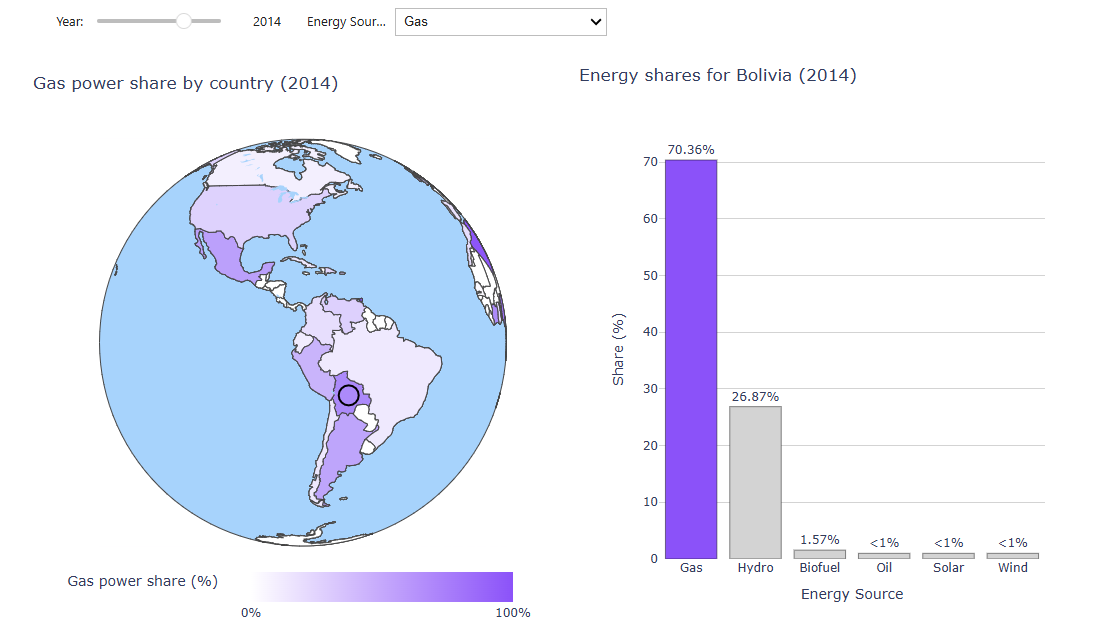

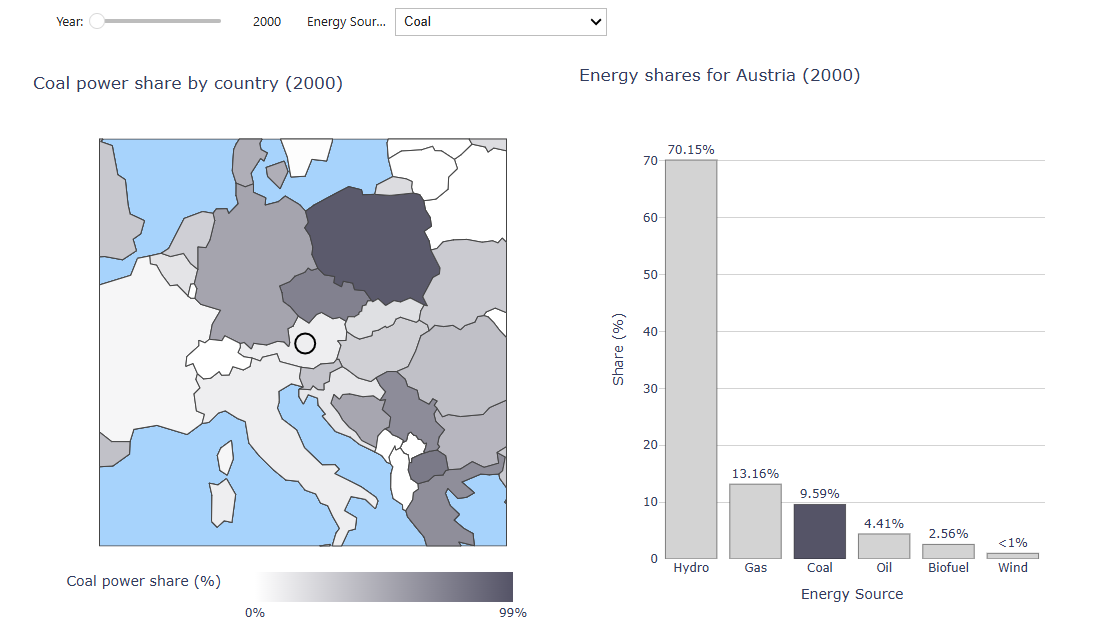

In [25]:
display(Image(filename='B1.1.png'))
display(Image(filename='B1.2.png'))

<b>To see the interactive visualization: [Click](https://github.com/jku-icg-classroom/visualization-lab-project-the-leading-figures/blob/master/project/sub_03_final/B1.mp4) </b>

Describe your visualizations and findings. Be clear which chart(s) you are referring to and relate your findings to the hypothesis/task.
Use no more than 150 words and indicate the word count of your description below.

**Description:** Interactive visualization provides users with information about the share of the selected energy source in the total electricity generation of countries worldwide in a particular year. Color shades of each country encode the share of the selected energy source, the value of which one can derive from the color scale or observe by hovering the mouse on the country.  By pinning the country using the double-click one can see the barplot about the total energy mix or total electricity generation of the pinned country. The values on top of the bars encode the share of energy types that make up the country's electricity generation.

**Word count**: 104

### B.2

Restate your hypothesis/task below.

**Hypthesis**/~~Task~~ **B.2**: Looking at the timeframe from 1991-2021, some countries (e.g., Austria, Germany …) are getting more energy efficient with regard to GDP growth, i.e., there is less additional energy consumption needed to increase GDP now compared to the 90s and 2000s. Since different countries place a different priority on becoming more energy efficient, comparing the gains in energy efficiency should reflect the differences in economic and ecological politics.

Place your visualizations below (max. 2). Make sure that everyting displays correctly in the GitHub file preview.

HTML(value='<h3>B2.1 Plot</h3>')

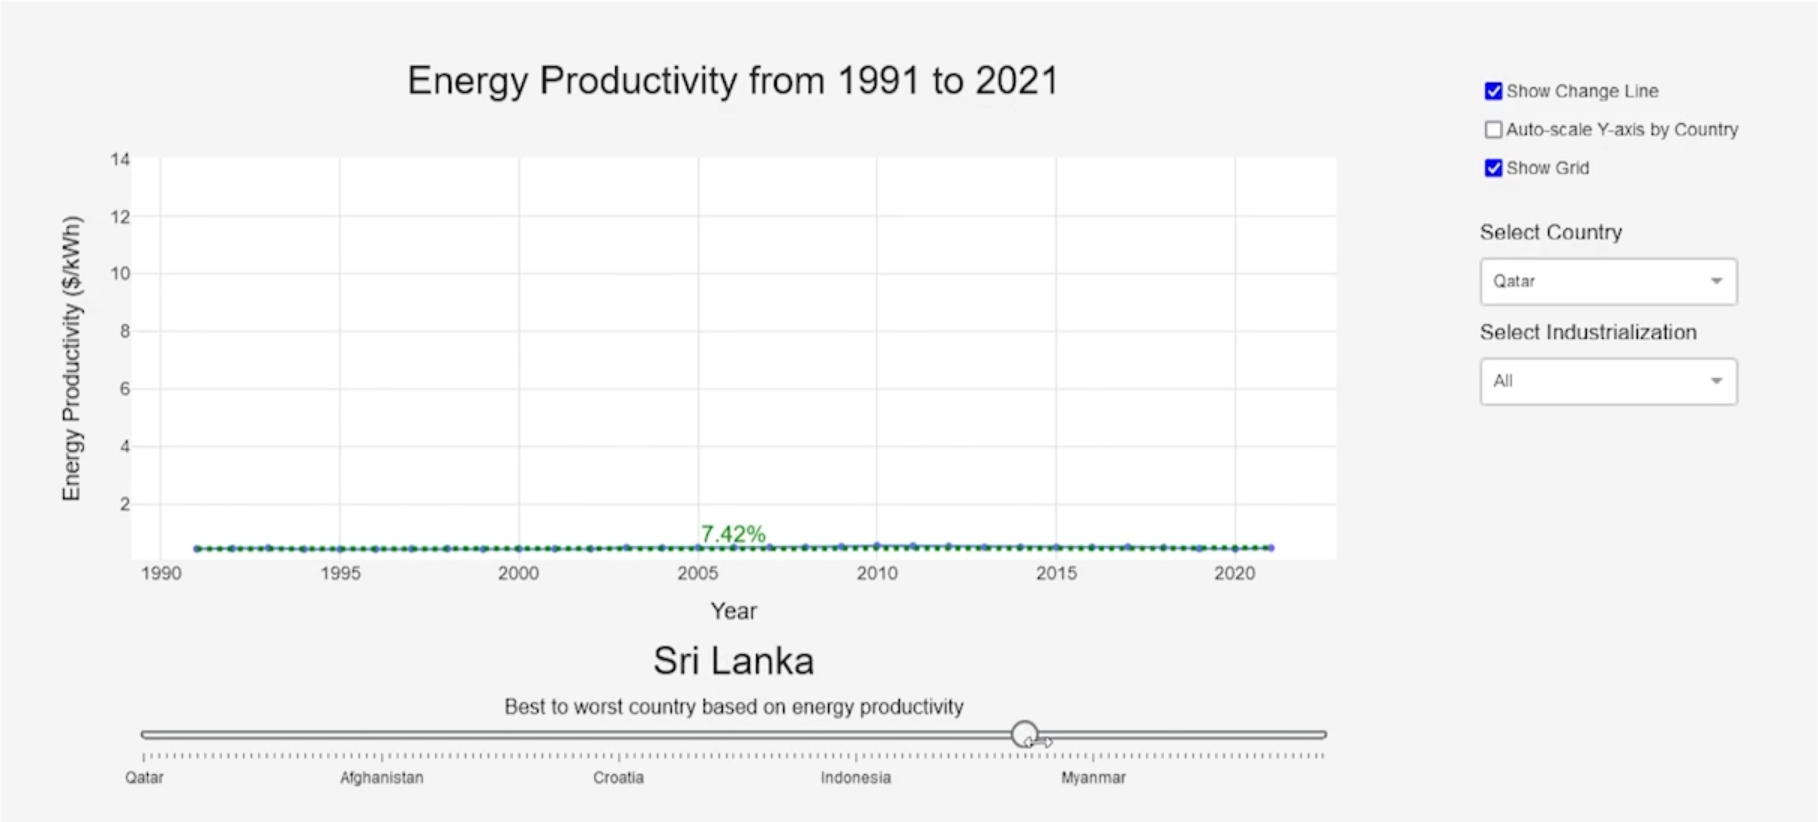

In [26]:
display(HTML("<h3>B2.1 Plot</h3>"))
display(Image(filename='plotB2_1_img.png'))

<b>To see the interactive visualization: [Click](https://github.com/jku-icg-classroom/visualization-lab-project-the-leading-figures/blob/master/project/sub_03_final/PlotB2_1.mp4) </b>

HTML(value='<h3>B2.2 Plot</h3>')

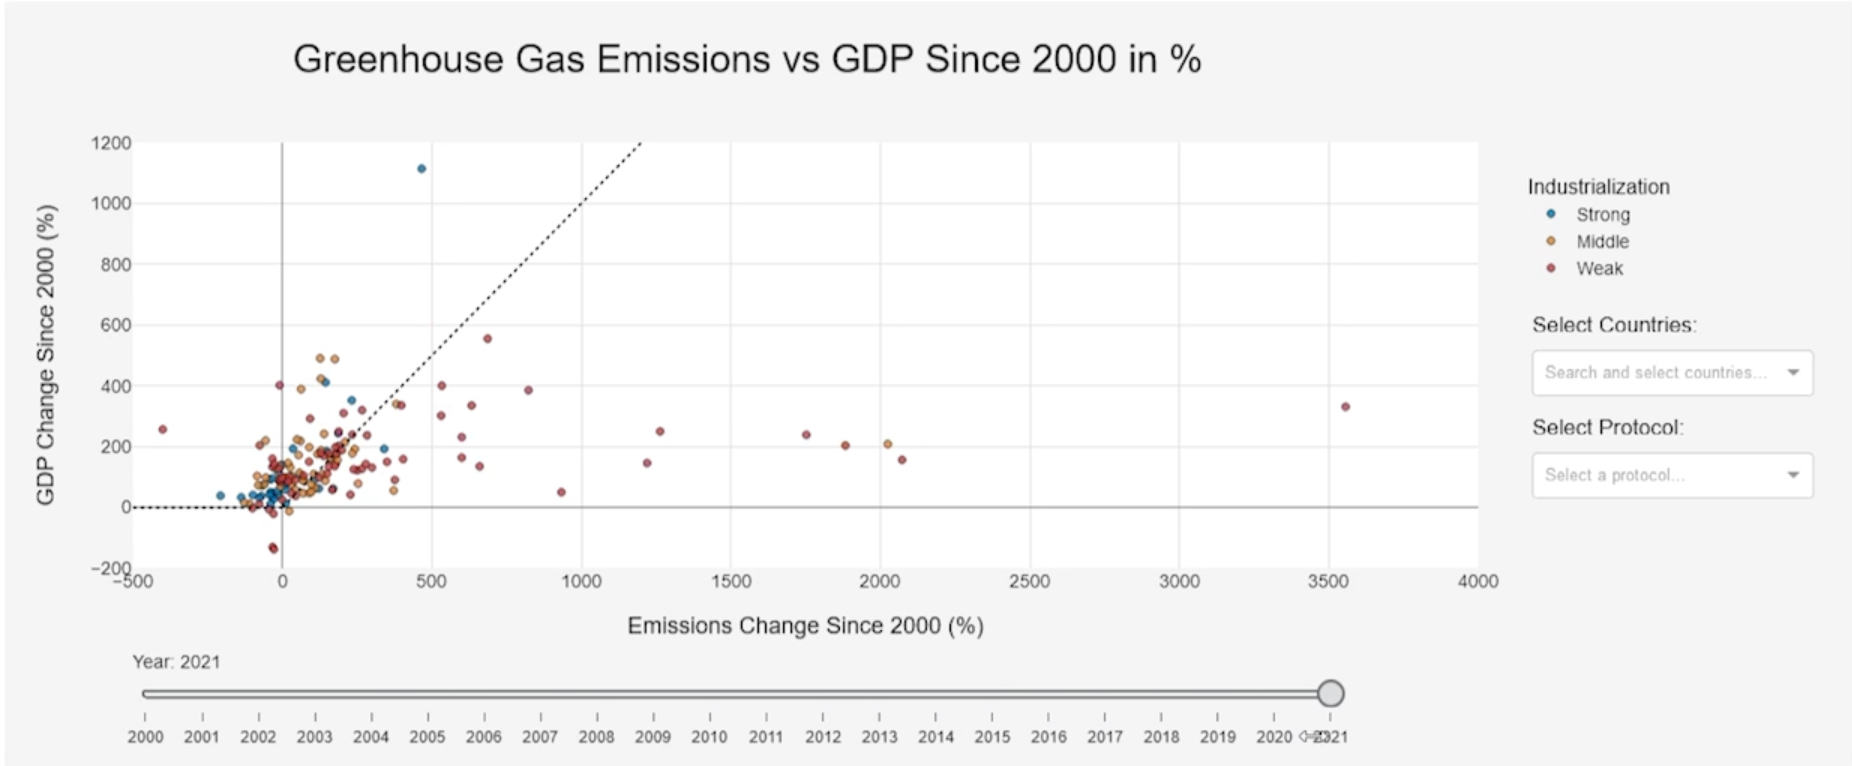

In [27]:
display(HTML("<h3>B2.2 Plot</h3>"))
display(Image(filename='plotB2_2_img.png'))

<b>To see the interactive visualization: [Click](https://github.com/jku-icg-classroom/visualization-lab-project-the-leading-figures/blob/master/project/sub_03_final/PlotB2_2.mp4)</b>

Describe your visualizations and findings. Be clear which chart(s) you are referring to and relate your findings to the hypothesis/task. Use no more than 150 words and indicate the word count of your description below.

**Description:** B2.1 shows a measure of energy efficiency over time. With the slider the user can switch countries which are sorted by efficiency gain over the timeframe. We couldn’t clearly separate by policies because the efficiency from which the country starts seems to have a strong influence as well as the level of industrialization. We added a dropdown menu to select a level of industrialization. We then found a better method by creating plot B2.2 which shows emission- instead of energy efficiency. For the X- and Y-Axis we plot the change of GDP and amount of emissions relative to the year 2000. (The negative X-Axis has a different scale since it’s minimum is -100% but the maximum can be +inf% theoretically, which would create a visual asymmetry) Here you can clearly separate countries by policies. If they are above the dashed line their efficiency increased (less pollution per GDP).


**Word count**: 148

---

## Results &ndash; Black-Hat Visualization

Place your black hat visualization below. Make sure that everything displays correctly in the GitHub file preview.

HTML(value='<h3>Black-Hat</h3>')

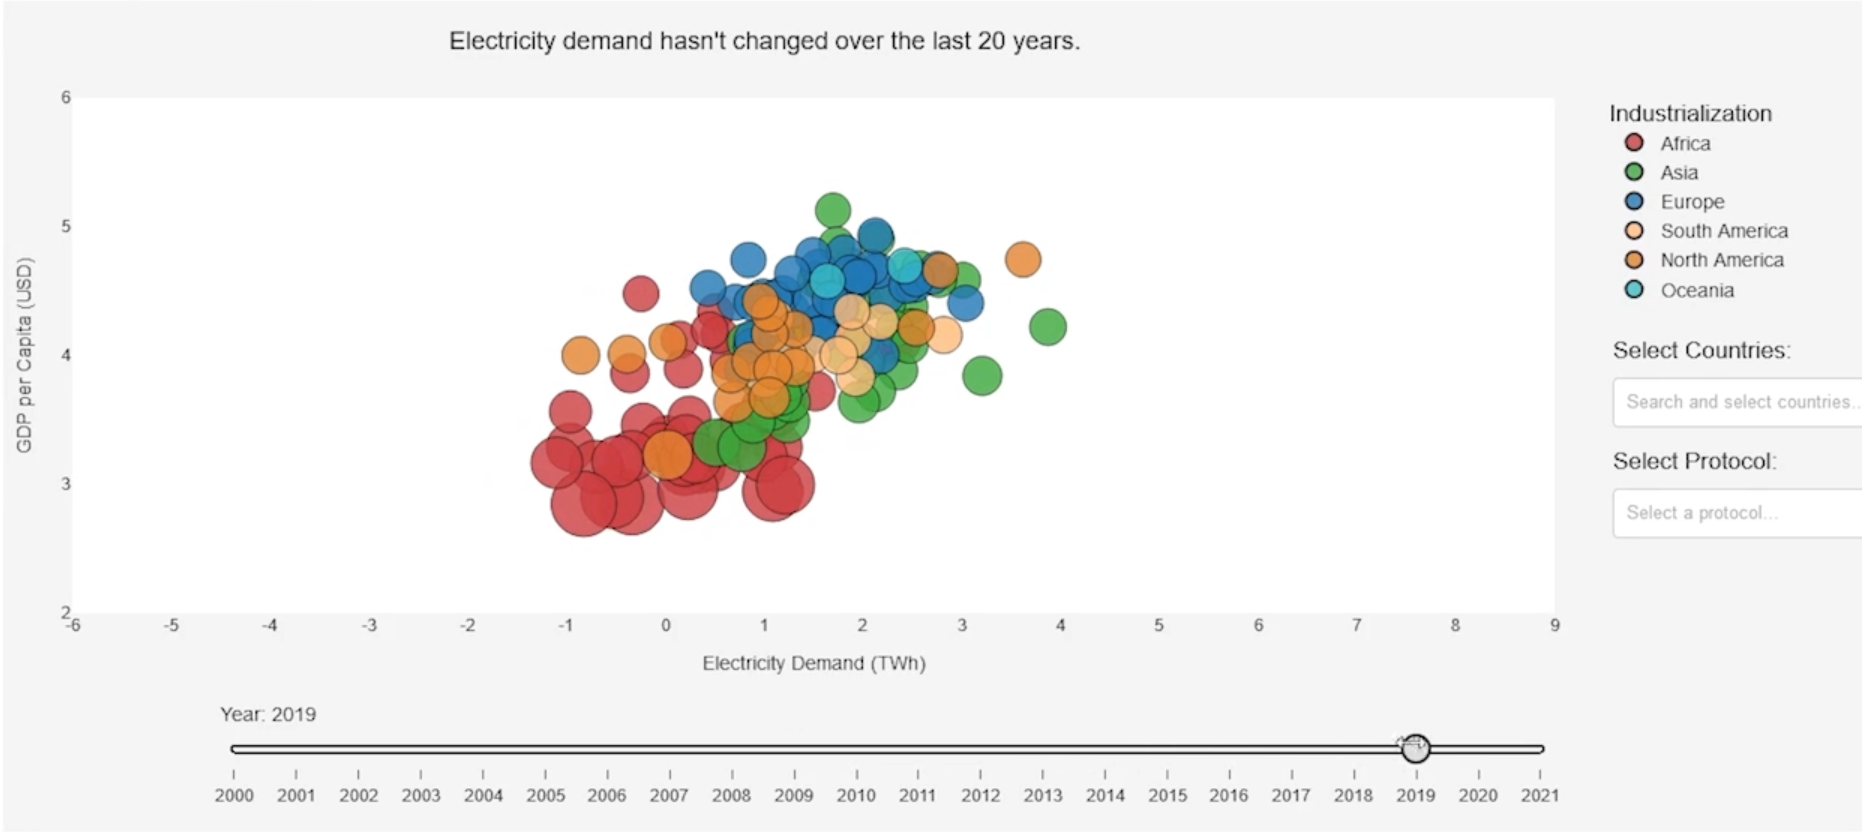

In [28]:
display(HTML("<h3>Black-Hat</h3>"))
display(Image(filename='plotblackhat_img.png'))

<b>To see the interactive visualization: [Click](https://github.com/jku-icg-classroom/visualization-lab-project-the-leading-figures/blob/master/project/sub_03_final/PlotBlackHat.mp4)</b>

Describe your black-hat visualization. What was your motivation? How did you achieve the desired effect? Use no more than 150 and indicate the word count of your description below.

**Description:** We wanted to give an obviously wrong hypothesis and modify the plot to give the impression that it is true. 
Hypothesis: “Electricity Demand did not change over the last 20 years.” To do this we use a logarithmic scale and only show the exponents. We made the range very large to make changes appear very small. We also used the title: "Electricity demand hasn't really changed over the last 20 years." To further manipulate the observer.
We also intentionally defined the size of the dots in an unreasonable way: The bigger the dots the smaller the GDP per capita is.


**Word count:** 100